In [75]:
import dolfin as dolf
from math import pi
from params import *
import numpy as np
from slepc4py import SLEPc

In [76]:
N = 400
size_M = (N+1)*2

In [77]:
def print_blockform(C):
    C = C.getValues(range(size_M), range(size_M))
    K = np.zeros_like(C)
    for i in range(N+1):
        for j in range(N+1):
            C_ij = C[2*i:2*i+2,2*j:2*j+2]
            K[i, j] = C_ij[0, 0]
            K[i, j+N+1] = C_ij[0, 1]
            K[i+N+1, j] = C_ij[1, 0]
            K[i+N+1, j+N+1] = C_ij[1, 1]
    return K

Now we define the mesh;

The definition of the subdomain and left and right boundaries will be changed.


In [78]:
def mshr(el):

    mesh = dolf.UnitIntervalMesh(el)

    def l_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 0.)

    def r_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 1.)

    boundaries = dolf.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)

    l_boundary = dolf.AutoSubDomain(l_boundary_func)
    r_boundary = dolf.AutoSubDomain(r_boundary_func)

    l_boundary.mark(boundaries, 1)
    r_boundary.mark(boundaries, 2)

    # ________________________________________________________________________________

    def fl_subdomain_func(x):
        x = x[0]
        x_f = params.x_f[0][0]
        a_f = params.a_f
        return x_f - a_f - dolf.DOLFIN_EPS <= x <= x_f + a_f + dolf.DOLFIN_EPS

    subdomains = dolf.MeshFunction('size_t', mesh, mesh.topology().dim())

    subdomains.set_all(1)

    fl_subdomain = dolf.AutoSubDomain(fl_subdomain_func)
    fl_subdomain.mark(subdomains, 0)

    return mesh, boundaries, subdomains

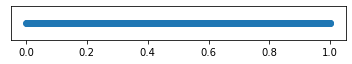

In [79]:
mesh, boundaries, subdomains = mshr(N)
dolf.plot(mesh)

In [80]:
boundary_conditions = {1: {'Robin': params.Y_in},  # inlet
                           2: {'Robin': params.Y_out}}  # outlet

In [81]:
degree = 1
c = params.c
constrained_domain=None

Now we will do Passive Flame Case Calculations;

In [82]:
dx = dolf.Measure('dx', domain=mesh)
ds = dolf.Measure('ds', domain=mesh, subdomain_data=boundaries)

CG = dolf.FiniteElement('CG', mesh.ufl_cell(), degree)
W = dolf.FunctionSpace(mesh, CG * CG, constrained_domain=constrained_domain)

function_space = W  #
u = dolf.TrialFunction(W)
v = dolf.TestFunction(W)

bcs = []

for i in boundary_conditions:
    if 'Dirichlet' in boundary_conditions[i]:
        for j in range(2):
            bc = dolf.DirichletBC(W.sub(j), 0.0, boundaries, i)
            bcs.append(bc)

## MATRIX A AND ITS ASSEMBLY

In [83]:
(u_1, u_2) = u
(v_1, v_2) = v

a_11 = - c ** 2 * dolf.dot(dolf.grad(v_1), dolf.grad(u_1)) * dx
a_22 = - c ** 2 * dolf.dot(dolf.grad(v_2), dolf.grad(u_2)) * dx
a_ = a_11 + a_22

dummy = (v_1 + v_2) * dx

A, b = dolf.assemble_system(a_, dummy, bcs)
A = dolf.as_backend_type(A).mat()
print_blockform(A)

array([[ -574.11764706,   574.11764706,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [  574.11764706, -1148.23529412,   574.11764706, ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,   574.11764706, -1148.23529412, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
         -800.        ,   400.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
          400.        ,  -800.        ,   400.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,   400.        ,  -400.        ]])

## MATRIX B AND ITS ASSEMBLY

In [84]:
(u_1, u_2) = u
(v_1, v_2) = v

N = function_space.dim()  # global size
istart, iend = function_space.dofmap().ownership_range()
n = iend - istart  # local size
print(N,n)

802 802


In [85]:
integrals_R = []

for i in boundary_conditions:
    if 'Robin' in boundary_conditions[i]:

        Y = boundary_conditions[i]['Robin']
        Y_r, Y_i = Y.real, Y.imag

        b_11 = - Y_i * c * v_1 * u_1 * ds(i)
        b_12 = - Y_r * c * v_1 * u_2 * ds(i)
        b_21 = + Y_r * c * v_2 * u_1 * ds(i)
        b_22 = - Y_i * c * v_2 * u_2 * ds(i)

        b_ = b_11 + b_12 + b_21 + b_22

        integrals_R.append(b_)

if integrals_R:

    b_ = sum(integrals_R)
    B = dolf.assemble(b_)
    B = dolf.as_backend_type(B).mat()

else:

    B = PETSc.Mat().create()
    B.setSizes([(n, N), (n, N)])
    B.setFromOptions()
    B.setUp()
    B.assemble()

B.getValues(range(size_M), range(size_M))

array([[-38.33720356, -17.97056417,  -0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 17.97056417, -38.33720356,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ -0.        ,  -0.        ,  -0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  -0.        ,
          0.        ,  -0.        ],
       [  0.        ,   0.        ,   0.        , ...,  -0.        ,
        -32.        , -15.        ],
       [  0.        ,   0.        ,   0.        , ...,  -0.        ,
         15.        , -32.        ]])

## ASSEMBLY OF C

In [86]:
(u_1, u_2) = u
(v_1, v_2) = v

c_11 = v_1 * u_1 * dx
c_22 = v_2 * u_2 * dx
c_   = c_11 + c_22

dummy = (v_1 + v_2) * dx

C, b = dolf.assemble_system(c_, dummy, bcs)
[bc.zero(C) for bc in bcs]
C = dolf.as_backend_type(C).mat()
C.getValues(range(size_M), range(size_M))

array([[0.00083333, 0.        , 0.00041667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00083333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00041667, 0.        , 0.00166667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00166667, 0.        ,
        0.00041667],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00083333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00041667, 0.        ,
        0.00083333]])

## PEP SOLVER

In [87]:
target = np.pi
nev = 1

In [88]:
E = SLEPc.PEP().create()

operators = [A, B, C]
E.setOperators(operators)

# Q.setProblemType(SLEPc.PEP.ProblemType.GENERAL)

# spectral transformation
st = E.getST()
st.setType('sinvert')

E.setTarget(target)
E.setWhichEigenpairs(SLEPc.PEP.Which.TARGET_MAGNITUDE)  # TARGET_REAL or TARGET_IMAGINARY

E.setDimensions(nev, SLEPc.DECIDE)
E.setTolerances(1e-15)
E.setFromOptions()

E.solve()

In [89]:
params.n = 0.16138844387770282

## ACTIVE FLAME

In [90]:
def n_tau(N3, tau):
    """
    :param N3: non-dimensional interaction index
    :param tau: time delay [s]
    :return: function
    """
    def inner_func(omega, k=0):
        return N3 * (1j * tau)**k * np.exp(1j * omega * tau)
    return inner_func

ftf = n_tau(params.n, params.tau)

In [96]:
gamma = 1.4
comm = None

mesh = mesh
subdomains = subdomains
x_f = params.x_f
x_r = np.array([[0.2, 0. , 0. ]])
rho_u = params.rho_in
FTF = ftf
degree = degree

coeff = (gamma - 1) / rho_u * 1. / 1.

In [ ]:
CG = dolf.FiniteElement('CG', mesh.ufl_cell(), degree)
W = dolf.FunctionSpace(mesh, dolf.MixedElement([CG, CG]), constrained_domain=constrained_domain)

function_space = W

In [98]:
def _helper_func(v, dofmap):
        indices = np.flatnonzero(v)
        values = v[indices]
        my_list = []
        for index, value in zip(indices, values):
            my_list.append([dofmap.dofs()[index], value])
        v = np.array(my_list)
        return v

### ASSEMBLE LEFT EIGENVECTOR

In [100]:
def assemble_left_vector(fl):
    (v_1, v_2) = dolf.TestFunction(function_space)
    dx = dolf.Measure('dx', subdomain_data=subdomains)

    V = dolf.FunctionSpace(mesh, 'CG', 1)
    const = dolf.interpolate(dolf.Constant(1), V)
    V_fl = dolf.assemble(const * dx(fl))

    a_1 = dolf.assemble(v_1 / V_fl * dx(fl))
    a_2 = dolf.assemble(v_2 / V_fl * dx(fl))

    dofmap = function_space.dofmap()

    a_1 = _helper_func(a_1, dofmap)
    a_2 = _helper_func(a_2, dofmap)

    a = (a_1, a_2)
    
    return a

### ASSEMBLE RIGHT EIGENVECTOR

In [109]:
def assemble_right_vector(x):    
    v = np.array([[0, 0, 1]])  # row
    dimension = mesh.geometric_dimension()
    if dimension == 1:
        v = np.array([[1]])
    elif dimension == 2:
        v = np.array([[1, 0]])
    # else:  # elif dimension == 3:
    #     pass
    v = v.transpose()  # column

    b = [np.array([]), np.array([])]

    cell_index = mesh.bounding_box_tree().compute_first_entity_collision(dolf.Point(*x))

    if cell_index <= mesh.num_entities(mesh.topology().dim()):

        cell = dolf.Cell(mesh, cell_index)

        b = []

        for j in range(2):

            dofmap = function_space.sub(j).dofmap()
            cell_dofs = dofmap.cell_dofs(cell_index)

            element = function_space.sub(j).element()
            d_dx = element.evaluate_basis_derivatives_all(1, x, cell.get_vertex_coordinates(), cell.orientation())

            d_dx = d_dx.reshape((len(cell_dofs), -1))

            d_dv = np.dot(d_dx, v)
            d_dv = d_dv[:, 0]

            my_list = []

            for i, dof in enumerate(cell_dofs):
                my_list.append([dofmap.tabulate_local_to_global_dofs()[dof], d_dv[i]])

            my_vec = np.array(my_list)

            b.append(my_vec)
        #
        # else:
        #
        #     pass

    return (*b, )

In [114]:
for fl, x in enumerate(x_r):
    a = assemble_left_vector(fl)
    print("left vector done")
    b = assemble_right_vector(x)
    print("right vector done")

left vector done
right vector done


### ASSEMBLING SUBMATRICES

In [116]:
def csr_matrix(a, b):

    # len(a) and len(b) are not the same

    nnz = len(a) * len(b)

    row = np.zeros(nnz)
    col = np.zeros(nnz)
    val = np.zeros(nnz)

    for i, c in enumerate(a):
        for j, d in enumerate(b):
            row[i * len(b) + j] = c[0]
            col[i * len(b) + j] = d[0]
            val[i * len(b) + j] = c[1] * d[1]

    row = row.astype(dtype='int32')
    col = col.astype(dtype='int32')

    return row, col, val

In [125]:
def assemble_submatrices(problem_type='direct'):

    num_fl = len(x_f)  # number of flames
    global_size = function_space.dim()
    local_size = len(function_space.dofmap().dofs())

    D_kj = dict()

    for k in range(2):
        for j in range(2):

            row = dict()
            col = dict()
            val = dict()

            for fl in range(num_fl):

                u = None
                v = None

                if problem_type == 'direct':
                    u = a[str(fl)][k]  # column vector
                    v = b[str(fl)][j]  # row vector

                elif problem_type == 'adjoint':
                    u = b[str(fl)][k]
                    v = a[str(fl)][j]

                row[str(fl)], col[str(fl)], val[str(fl)] = csr_matrix(u, v)

            row = np.concatenate([row[str(fl)] for fl in range(num_fl)])
            col = np.concatenate([col[str(fl)] for fl in range(num_fl)])
            val = np.concatenate([val[str(fl)] for fl in range(num_fl)])

            i = np.argsort(row)

            row = row[i]
            col = col[i]
            val = val[i]

            indptr = np.bincount(row, minlength=local_size)
            indptr = np.insert(indptr, 0, 0).cumsum()
            indptr = indptr.astype(dtype='int32')

            mat = PETSc.Mat().create(comm=comm)
            mat.setSizes([(local_size, global_size), (local_size, global_size)])
            mat.setType('aij')
            mat.setUp()

            mat.setValuesCSR(indptr, col, val)
            mat.assemblyBegin()
            mat.assemblyEnd()

            D_kj['{0}{1}'.format(k + 1, j + 1)] = mat
    if problem_type == 'direct':
        return (D_kj['11'], D_kj['12'], D_kj['21'], D_kj['22'])
    elif problem_type == 'adjoint':
        return (D_kj['11'], D_kj['12'], D_kj['21'], D_kj['22'])

In [124]:
D = assemble_submatrices(problem_type='direct')

IndexError: invalid index to scalar variable.

## NORMALIZATION OF EIGENVECTORS

In [ ]:

omega = 0.
A = E.getOperators()[0]
vr, vi = A.createVecs()

eig = E.getEigenpair(1, vr, vi)
omega = eig
omega


In [ ]:
V = dolf.FunctionSpace(mesh, "CG", degree, constrained_domain=constrained_domain)
CG = dolf.FiniteElement("CG", mesh.ufl_cell(), degree)
W = dolf.FunctionSpace(mesh, dolf.MixedElement([CG, CG]), constrained_domain=constrained_domain)

vr_1 = vr.getArray()[0::2]
vr_2 = vr.getArray()[1::2]
vi_1 = vi.getArray()[0::2]
vi_2 = vi.getArray()[1::2]

x = vr_1 - vi_2 + 1j * (vr_2 + vi_1)

x_r = x.real
x_i = x.imag

p_r = dolf.Function(V)
p_i = dolf.Function(V)

p_r.vector().set_local(x_r)
p_r.vector().apply('insert')
p_i.vector().set_local(x_i)
p_i.vector().apply('insert')

dx = dolf.Measure('dx')
meas = dolf.assemble((p_r * p_r + p_i * p_i) * dx)
meas = np.sqrt(meas)
# print(meas)

x /= meas

x_r = x.real
x_i = x.imag

# p_r.vector().set_local(x_r)
# p_r.vector().apply('insert')
# p_i.vector().set_local(x_i)
# p_i.vector().apply('insert')
#
# meas = dolf.assemble((p_r * p_r + p_i * p_i) * dx)
# meas = np.sqrt(meas)
# # print(meas)

x = vr.copy()

istart, iend = x.getOwnershipRange()

x[istart:iend:2] = x_r
x[istart+1:iend+1:2] = x_i

p = dolf.Function(W)
p.vector().set_local(x.getArray())
p.vector().apply('insert')

In [ ]:
p_r, p_i = p.split(True)
dolf.plot(p_r)

In [ ]:
dolf.plot(p_i)